In [1]:
import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import autograd

import copy
from scipy import optimize

import os
import json

import time

import pickle


In [2]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.

simulate_data = False

if not simulate_data:
    #analysis_name = 'simulated_data_small'
    #analysis_name = 'simulated_data_large'
    analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'],
                            'LinearResponseVariationalBayes.py/Models/LogisticGLMM/data')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)

    json_file = open(json_filename, 'r')
    json_dat = json.load(json_file)
    json_file.close()

    stan_dat = json_dat['stan_dat']
    #vp_base = json_dat['vp_base']

    print(stan_dat.keys())
    K = stan_dat['K'][0]
    NObs = stan_dat['N'][0]
    NG = stan_dat['NG'][0]
    #N = NObs / NG
    y_g_vec = np.array(stan_dat['y_group'])
    y_vec = np.array(stan_dat['y'])
    x_mat = np.array(stan_dat['x'])
    
    glmm_par = logit_glmm.get_glmm_parameters(K=K, NG=NG)

    # Define a class to contain prior parameters.
    prior_par = logit_glmm.get_default_prior_params(K)
    prior_par['beta_prior_mean'].set(np.array(stan_dat['beta_prior_mean']))

    prior_par['beta_prior_info'].set(np.array(stan_dat['beta_prior_info']))

    prior_par['mu_prior_mean'].set(stan_dat['mu_prior_mean'][0])
    prior_par['mu_prior_info'].set(stan_dat['mu_prior_info'][0])
    
    prior_par['tau_prior_alpha'].set(stan_dat['tau_prior_alpha'][0])
    prior_par['tau_prior_beta'].set(stan_dat['tau_prior_beta'][0])
    
    # An index set to make sure jacobians match the order expected by R.
    prior_par_indices = copy.deepcopy(prior_par)
    prior_par_indices.set_name('Prior Indices')
    prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))
else:
    # Simulate data instead of loading it if you like
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    # Generate data

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)

    prior_par = logit_glmm.get_default_prior_params(K)

    glmm_par = logit_glmm.get_glmm_parameters(
        K=K, NG=NG, 
        mu_info_min=0.001, tau_alpha_min=0.001,
        tau_beta_min=0.001, beta_diag_min=0.001,
        u_info_min=0.001)


print(np.mean(y_vec))

dict_keys(['mu_prior_info', 'y', 'K', 'beta_prior_info', 'tau_prior_alpha', 'tau_prior_beta', 'beta_prior_mean', 'x', 'y_group', 'NG', 'N', 'mu_prior_mean'])
0.324


In [3]:


glmm_init = False
if glmm_init and not simulate_data:
    # Initialize with GLMM.
    # If you use this, don't forget to add the computation time to your final VB time!
    glmm_time = 0.

    glmm_fit = json_dat['glmm_fit']
    glmm_par['mu'].mean.set(glmm_fit['mu_mean'][0])
    glmm_par['mu'].info.set(1.0)

    tau_mean = 1.0 / glmm_fit['mu_sd'][0] ** 2
    tau_var = 1.0
    glmm_par['tau'].shape.set((tau_mean ** 2) / tau_var)
    glmm_par['tau'].rate.set(tau_var / tau_mean)

    glmm_par['beta'].mean.set(np.array(glmm_fit['beta_mean']))
    #glmm_par['beta'].info.set(np.eye(K))
    glmm_par['beta'].info.set(np.ones(K))

    glmm_par['u'].mean.set(np.array(glmm_fit['u_map']))
    glmm_par['u'].info.set(np.full(NG, 1.0))

    free_par_vec = glmm_par.get_free()
else:
    glmm_time = 0.
    glmm_par['mu'].mean.set(0.0)
    glmm_par['mu'].info.set(1.0)

    glmm_par['tau'].shape.set(2.0)
    glmm_par['tau'].rate.set(2.0)

    glmm_par['beta'].mean.set(np.full(K, 0.0))
    #glmm_par['beta'].info.set(np.eye(K))
    glmm_par['beta'].info.set(np.ones(K))

    glmm_par['u'].mean.set(np.full(NG, 0.0))
    glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [4]:
# Define moment parameters
moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = autograd.jacobian(moment_wrapper.get_moment_vector)
moment_jac = get_moment_jacobian(init_par_vec)


In [5]:
model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points=10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
def get_e_log_prior(prior_vec, free_par):
    model.glmm_par.set_free(free_par)
    model.prior_par.set_vector(prior_vec)
    return model.get_e_log_prior()

get_prior_model_grad = autograd.grad(get_e_log_prior, argnum=0)
get_prior_hess = autograd.jacobian(get_prior_model_grad, argnum=1)

import timeit

time_num = 10

num_draws = 3
model.set_gh_points(num_draws)
print('num_draws = ', num_draws)
print('\tFunction time:',
      timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('\tGrad time:', 
      timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('\tHessian vector product time:',
      timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

prior_vec = model.prior_par.get_vector()
prior_hess_time = time.time()
get_prior_hess(prior_vec, init_par_vec)
prior_hess_time = time.time() - prior_hess_time
print('\tPrior hess time: ', prior_hess_time)


num_draws =  3
	Function time: 0.0005696916952729226
	Grad time: 0.005049766303272918
	Hessian vector product time: 0.010496326099382714
	Prior hess time:  0.056894540786743164


In [6]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_gh_points, gtol=1e-6, maxiter=500):
    model.set_gh_points(num_gh_points)
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': gtol })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [7]:
import pandas as pd
#print(glmm_par)

x_t_x = np.matmul(x_mat.transpose(), x_mat)
x_t_y = np.matmul(x_mat.transpose(), y_vec)
beta_init = np.linalg.solve(x_t_x, x_t_y)
#print(beta_init)
#plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
#print(df.sum())
u_init = np.array(df.sum()) / np.array(df.count()['y'])
#plt.figure()
print(np.min(y_g_vec))
#plt.plot(u_init[y_g_vec], y_vec, 'k.')


0


In [8]:
# Optimize.

print('Running Newton Trust Region.')
num_gh_points = 4
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_gh_points, gtol=1e-6, maxiter=500)
vb_time_opt_1 = time.time() - vb_time
#print('vb_time_opt_1: ', vb_time_opt_1)
vb_time = time.time() - vb_time

# print('Running Newton Trust Region with more draws')
# num_gh_points = 20
# # vb_time = time.time()
# opt_x = tr_optimize(opt_x, num_gh_points, gtol=1e-6, maxiter=100)
# vb_time = time.time() - vb_time

print('VB time: ', vb_time)
print('Done.')

Running Newton Trust Region.
Iter  0  value:  1034.44059918
	x_diff:  inf
Iter  5  value:  235.257298461
	x_diff:  1.33334382258
Iter  10  value:  72.6398068113
	x_diff:  1.49037294097
Iter  15  value:  69.409569197
	x_diff:  0.068452021885
Optimization terminated successfully.
         Current function value: 69.407873
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
         Hessian evaluations: 0
VB time:  2.3485257625579834
Done.


In [9]:

glmm_par.set_free(opt_x)
if simulate_data:
    print('Fit beta: ', glmm_par['beta'].e())
    print('True beta: ', true_beta)
    
    print('Fit mu: ', glmm_par['mu'].e())
    print('True mu: ', true_mu)
    
    print('Fit tau: ', glmm_par['tau'].e())
    print('True tau: ', true_tau)
    
    plt.plot(true_u, true_u, 'r.')
    plt.plot(true_u, glmm_par['u'].e(), 'k.')
    

In [10]:
print(vb_time_opt_1)
print(vb_time - vb_time_opt_1)


2.3485023975372314
2.3365020751953125e-05


VB time:  2.3485257625579834
[ 0.72808542  1.89807706  3.30921453  4.19010817  5.24256281]
GLMM Parameters:
	mu:
mu_mean: [-3.58726387]
mu_info: [ 101.79778182]
	tau:
tau_shape: [ 53.]
tau_rate: [ 52.06911778]
	beta:
beta_mean:
[ 0.72808542  1.89807706  3.30921453  4.19010817  5.24256281]
beta_info:
[ 19.89797848  19.93550981  14.07405886  15.78453625  13.43869674]
	u:
u_mean:
[-3.07304073 -3.57646071 -3.7791838  -4.44366275 -3.51762941 -3.88706906
 -3.69985985 -3.76609831 -2.73986117 -3.47784522 -2.78587645 -3.27133411
 -3.71936898 -3.7974952  -3.59128081 -3.06523949 -3.30457884 -4.17338945
 -3.80209026 -3.03252421 -2.59012987 -3.66009584 -3.65781285 -4.55794505
 -3.2410674  -4.2917967  -3.65010274 -3.59102336 -3.26594785 -2.95183154
 -3.55973812 -3.22134048 -3.51683058 -3.91246447 -3.18961261 -5.26932803
 -3.75643143 -3.80160914 -3.99667242 -3.37721689 -3.71338164 -3.50024497
 -2.90663555 -4.46218528 -4.199366   -4.08786128 -3.04806831 -3.73155779
 -3.18446567 -3.52520178 -3.37920465

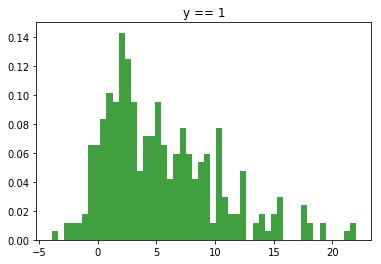

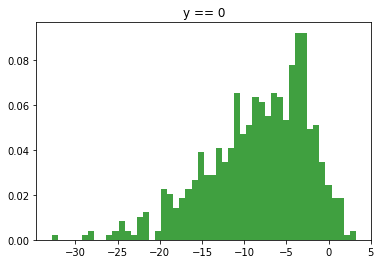

In [11]:
print('VB time: ', vb_time)

import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
#glmm_par_opt.set_free(init_par_vec)
print(glmm_par_opt['beta'].e())
print(glmm_par_opt)

#plt.plot(glmm_par_opt['u'].e(), glmm_par_opt['u'].var(), 'k.')

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)
#plt.plot(sp.special.expit(z_mean), model.y_vec, 'k.')

plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [12]:
# In case you want to save without calculating the Hessian, instantiate them here
hess_time = 0.
log_prior_hess = np.array([0.])
elbo_hess = np.array([0.])
moment_jac = np.array([0.])
lrvb_cov = np.array([0.])

In [15]:
# Get the Hessians at the number of draws used for optimization
sparse_model = logit_glmm.SparseModelObjective(glmm_par, prior_par, x_mat, y_vec, y_g_vec, num_gh_points)
sparse_model.glmm_par.set_free(opt_x)

hess_time = time.time()
print('KL Hessian...\n')
#kl_hess = objective.fun_free_hessian(opt_x)
sparse_vector_hess = \
    sparse_model.get_sparse_vector_hessian(print_every_n=50)
elbo_hess = sparse_model.get_free_hessian(sparse_vector_hess)

print('Log prior Hessian...\n')
log_prior_hess = get_prior_hess(prior_par.get_vector(), opt_x)

hess_time =  time.time() - hess_time

print('hess_time: %f' % hess_time)

KL Hessian...

Calculating global hessian:
Group 0 of 0
Done.
Calculating local hessian:
Group 0 of 99
Group 50 of 99
Done.
Log prior Hessian...

hess_time: 8.150822


/home/rgiordan/Documents/git_repos/autograd/autograd/core.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [17]:
print(sparse_vector_hess)

  (0, 0)	-101.797781814
  (0, 2)	-0.000676842239587
  (0, 3)	0.000688942702054
  (0, 14)	1.01787781814
  (0, 15)	1.01787781814
  (0, 16)	1.01787781814
  (0, 17)	1.01787781814
  (0, 18)	1.01787781814
  (0, 19)	1.01787781814
  (0, 20)	1.01787781814
  (0, 21)	1.01787781814
  (0, 22)	1.01787781814
  (0, 23)	1.01787781814
  (0, 24)	1.01787781814
  (0, 25)	1.01787781814
  (0, 26)	1.01787781814
  (0, 27)	1.01787781814
  (0, 28)	1.01787781814
  (0, 29)	1.01787781814
  (0, 30)	1.01787781814
  (0, 31)	1.01787781814
  (0, 32)	1.01787781814
  (0, 33)	1.01787781814
  (0, 34)	1.01787781814
  (0, 35)	1.01787781814
  :	:
  (212, 5)	0.00840757366669
  (212, 6)	-0.00999293581057
  (212, 7)	-0.00661511514662
  (212, 8)	0.0161655150878
  (212, 9)	9.9297604595e-06
  (212, 10)	-7.85453628865e-06
  (212, 11)	2.97896089069e-05
  (212, 12)	-2.28980558797e-06
  (212, 13)	2.19181331132e-06
  (212, 112)	0.0424180224114
  (212, 212)	-0.193703786694
  (213, 2)	0.00382069311428
  (213, 3)	-0.00388899877094
  (213, 4

In [26]:
moment_jac = get_moment_jacobian(opt_x)
#lrvb_cov = -1 * np.matmul(moment_jac, np.linalg.solve(elbo_hess, moment_jac.T))
lrvb_cov = -1 * np.matmul(moment_jac, sp.sparse.linalg.spsolve(elbo_hess, moment_jac.T))
vb_prior_sens = -1 * np.matmul(moment_jac, sp.sparse.linalg.spsolve(elbo_hess, log_prior_hess.T))


In [27]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    # JSON doesn't support sparse matrices (I don't think) and I'm not using it anyway.
#     result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
#                     'vb_time': vb_time, 'hess_time': hess_time, 'num_gh_points': num_gh_points, 
#                     'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
#                     'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

#     result_json = json.dumps(result_dict)
#     json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)
#     json_file = open(json_output_filename, 'w')
#     json_file.write(result_json)
#     json_file.close()
#     print(json_output_filename)
    
    pickle_output_filename = os.path.join(data_dir, '%s_python_vb_results.pkl' % analysis_name)
    pickle_output = open(pickle_output_filename, 'wb')

    # TODO: save everything needed to reconstruct glmm_par, since the parameters cannot be pickled
    # due to having function pointers.
    # Unlike with JSON, numpy arrays can be pickled.
    pickle_result_dict = {  'glmm_par_dictval': glmm_par_opt.dictval(),
                            'glmm_par_vector': glmm_par_opt.get_vector(),
                            'glmm_par_free': glmm_par_opt.get_free(),
                            'run_name': run_name,
                            'vb_time': vb_time,
                            'hess_time': hess_time,
                            'num_gh_points': num_gh_points, 
                            'lrvb_cov': np.squeeze(lrvb_cov),
                            'moment_jac': np.squeeze(moment_jac),
                            'elbo_hess': np.squeeze(elbo_hess),
                            'vb_prior_sens': np.squeeze(vb_prior_sens),
                            'log_prior_hess': np.squeeze(log_prior_hess) }

    # Pickle dictionary using protocol 0.
    pickle.dump(pickle_result_dict, pickle_output)
    pickle_output.close()
    
    print(pickle_output_filename)


print('\n\nDONE.')
    

/home/rgiordan/Documents/git_repos/LinearResponseVariationalBayes.py/Models/LogisticGLMM/data/simulated_data_small_python_vb_results.pkl


DONE.
